<h1><center>Introduction to the package SABS-BFGS</center></h1>
<h3><center>Author: Yiming Wei</center></h3>
<h3><center>Date: 2023-02-10</center></h3>

This is an introduction to an individual project in the Modelling and Scientific Computing module in the SABS programme.

Briefly speaking, we build up a package to implement the [BFGS Algorithm](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm) for global optimisation.

In the following section, we will introduce the package at successively increasing levels of detail, which includes:
* How to use it.
* How it works.
* How it works (if you are a bit interested in details).
* How it works (if you are a mathematician).

Let's get started!

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib notebook

from SABS_BFGS.traceplot import TracePlot
from SABS_BFGS.bfgs import BFGS
from SABS_BFGS.example_function import Resenbrock

### Section 1: How to use it

**Example 1: Find the global optimum of univariate function $f(x)=x^2$** 

In [4]:
bfgs = BFGS()
x0 = 1.0
x_argmin, f_min = bfgs.minimize(lambda x: x**2, x0)

In [5]:
print('Global minimum: ',x_argmin)
print('Minimal Value: ',format(float(f_min),".2f"))

Global minimum:  [0.]
Minimal Value:  0.00


**Example 2: Find the global optimum of multivariate function $f(x,y) = (1 - x)^2 + (y - x ^ 2)^2$**

In [6]:
def func(x):
    return (1 - x[0]) ** 2 + (x[1] - x[0] ** 2) ** 2

In [7]:
bfgs = BFGS()
x0 = np.array([1.2,1.2])
x_argmin,fmin = bfgs.minimize(func,x0)

In [8]:
print('Global minimum: ',np.round(x_argmin,decimals=2))
print('Minimal Value: ',format(float(f_min),".2f"))

Global minimum:  [1. 1.]
Minimal Value:  0.00


### Section 2: How it works 

In this section, we will give an visualisation of the algorithm for those not interested in details.

In [9]:
# Load the function class Resenbrock, which have the information on first and second order derivatives.
fun_class = Resenbrock()
x0 = np.array([1.2, 1.2])
bfgs = BFGS()
x_argmin, f_min, trace_bfgs = bfgs.minimize(fun_class.fun, x0, return_trace=True)
print('The Global Minimum point:', x_argmin)
print('Corresponding global minimal value: ',format(f_min,".2f"))

The Global Minimum point: [1. 1.]
Corresponding global minimal value:  0.00


The following animation illustrates how BFGS finds the global minimum $(1,1)$ starting from $(1.2,1.2)$.

<IPython.core.display.Javascript object>


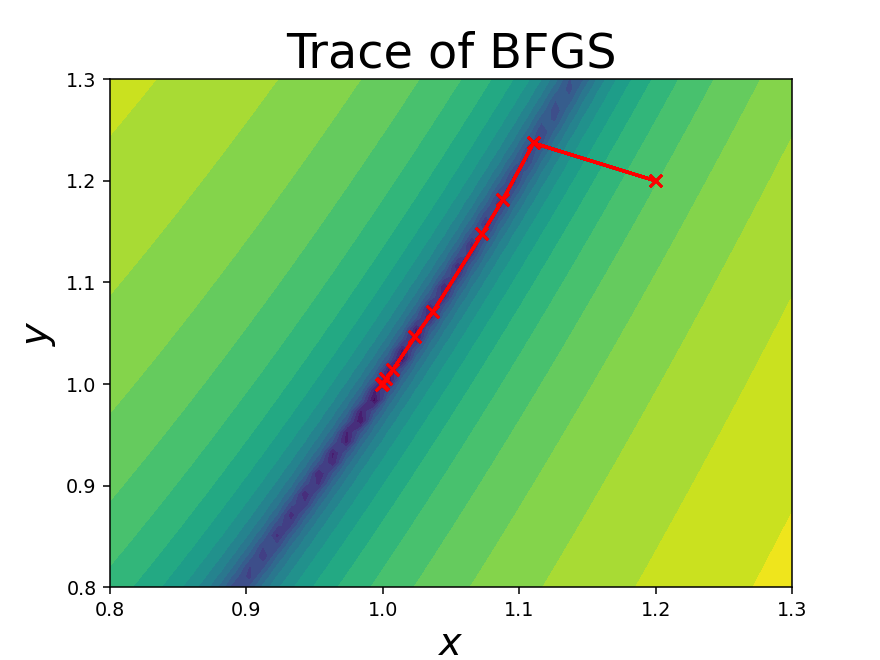

In [18]:
traceplot = TracePlot(fun_class,xlim=[0.8,1.3],ylim=[0.8,1.3],x_resolution=50,y_resolution=50,plot_log=True)
step_number = traceplot.prepare_trace(trace_bfgs['x_k'])
fig1, ax1 = plt.subplots()
ax1.set_title('Trace of BFGS',fontsize=25)
ax1.set_xlabel(r'$x$',fontsize=20)
ax1.set_ylabel(r'$y$',fontsize=20)
traceplot.plot_contour(ax1)
ani = animation.FuncAnimation(fig1, traceplot.animate, np.arange(1, step_number-1), #init_func=init,
                              interval=5000/(step_number-1), blit=True)
#file_name = "BFGS_visualisation.gif" 
#writergif = animation.PillowWriter(fps=2) 
#ani.save(file_name, writer=writergif)

### Section 3: How it works (if you are a bit interested in details)

Previously, we have shown the trace of BFGS method. It converged within 12 steps! Really efficient!

Now let's make a comparison with traditional gradient descent method, and see what's happening. 

In [11]:
from SABS_BFGS.other_optimisation_methods import GradientDescent
gradient_descent = GradientDescent()
x0 = np.array([1.2, 1.2])
x_argmin, f_min, trace_gd = gradient_descent.minimize(fun_class.fun, x0, tol=1e-2,alpha=0.001,return_trace=True)
print('The Global Minimum point:', x_argmin)
print('Corresponding global minimal value: ',fmin)

The Global Minimum point: [1.0112807 1.0227333]
Corresponding global minimal value:  2.1251638312386637e-18


<IPython.core.display.Javascript object>


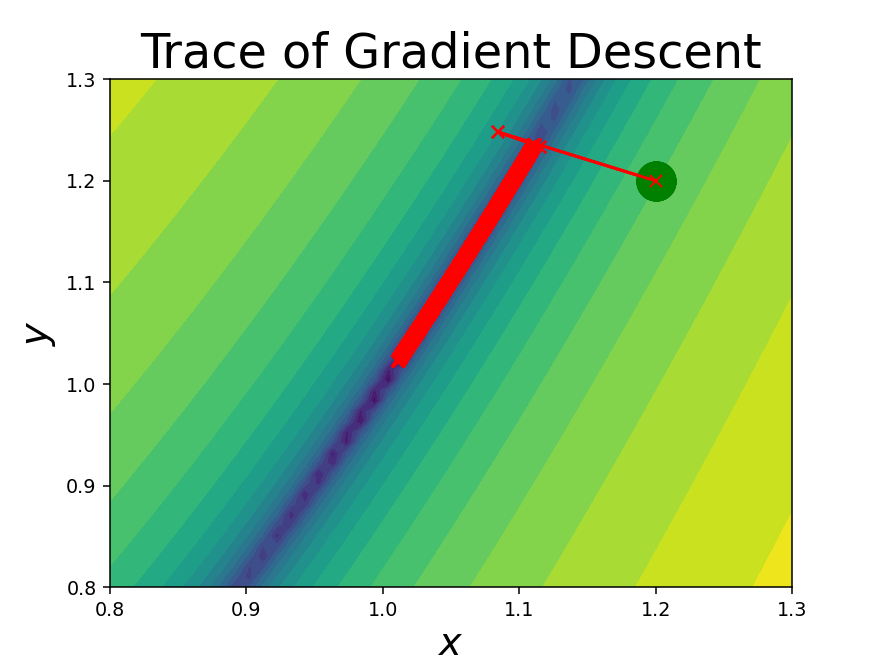

In [12]:
traceplot = TracePlot(fun_class,xlim=[0.8,1.3],ylim=[0.8,1.3],x_resolution=50,y_resolution=50,plot_log=True)
fig2, ax2 = plt.subplots()
ax2.set_title('Trace of Gradient Descent',fontsize=25)
ax2.set_xlabel(r'$x$',fontsize=20)
ax2.set_ylabel(r'$y$',fontsize=20)
traceplot.plot_contour(ax2)


# Plot the Gradient Descent Trace
step_number = traceplot.prepare_trace(trace_gd['x_k'])
ani = animation.FuncAnimation(fig2, traceplot.animate, np.arange(0, step_number-1), #init_func=init,
                              interval=5000/(step_number-1), blit=True)

Oh, it converged slowly! You must be impatient since the gradient descent plot is still running! Some people might argue that we can use larger step to accelerate convergence. Now uncomment the following codes and set the step size to $0.01$.

In [13]:
#gradient_descent = GradientDescent()
#x0 = np.array([1.2, 1.2])
#x_argmin, f_min, trace_gd = gradient_descent.minimize(fun_class.fun, x0, tol=1e-2,alpha=0.01,return_trace=True)

Something unexpected happens! The long, narrow "valley" in the Rosenbrock function is pathological and makes things difficult. In fact, Rosenbrock function is often used as a test function for optimisation methods.

BFGS elegently solves this problem with two tricks
1. choose the *optimal* descent direction by using the second order derivative information (Hessian matrix).
2. Adaptively choose the *optimal* step size (line search).

Let me explain the *optimal direction* first. The idea is to consider the Taylor expansion of $f$ at the current point $x_k$, i.e. $m_k(p)$ is an approximation of function $f$ around point $x_k$.

$$
f(x_k + p) \approx f(x_k) + p^\mathrm{T}\nabla f(x_k)+\frac{1}{2}p^\mathrm{T}\nabla^2f(x_k)p\triangleq m_k(p)
$$

And then we find can find the global minimum of direction $p_k= -(\nabla^2f(x_k))^{-1}\nabla f(x_k)$.

Practically, BFGS does **not** directly calculate $\nabla^2f(x_k)$, but uses $\nabla f(x_k)$ to estimate it. Moreover, it uses [Sherman–Morrison formula](https://en.wikipedia.org/wiki/Sherman%E2%80%93Morrison_formula) to avoid computing the matrix inverse, reducing the complexity to $O(n^2)$.

Once the direction has been picked up, BFGS searches for the optimal step size $\alpha_k = \underset{\alpha}{\textrm{argmin }} f(x_k + \alpha p_k)$, which is called [line search](https://en.wikipedia.org/wiki/Line_search). Practically, it is implemented using approximation approaches. Then we set $x_{k+1} = x_k + \alpha_k p_k$. The algorithm proceeds until convergence.

### Section 4: How it works (if you are a mathematician)

In this section, we will describe the BFGS algorithm in a mathematician-style. If you are not interested in math, just skip it.

The global optimisation problem can be formalised as
$$
\underset{\textbf{x}}{\textrm{argmin }} f(\textbf{x})\\
x\in\mathbb{R}^n
$$

As described in previous sections, BFGS runs in an iterative way. In each iteration $k$, we do the following steps:
1. At $x_k$, get the derivative and Hessian matrix $\nabla f(x_k), B_k$ of the function.
2. Solve $p_k = -B_k^{-1}\nabla f(x_k)$.
3. Find the optimal step size by $\alpha_k = \underset{\alpha}{\textrm{argmin }} f(x_k + \alpha p_k)$.
4. Update $x_{k+1} = x_k + \alpha_k p_k$.
5. Update the approximation of Hessian matrix by solving $B_{k+1}(x_{k+1}-x_k) = \nabla f(x_{k+1}) - \nabla f(x_k)$.

Remarks:
* Step 3 is solved by [line search](https://en.wikipedia.org/wiki/Line_search), which returns $\alpha_k$ and ensures that $x_{k+1} = x_k + \alpha_kp_k$  satisfies [Wolfe conditions](https://en.wikipedia.org/wiki/Wolfe_conditions).
* We usually set the initial estimation of Hessian as identity matrix $B_0=I$, and the inital $x_0$ is specified by the user.
* Practically, $B_{k+1}$ is not derived by solving equation in step 5. Instead, we denote $s_k = x_{k+1}-x_k$, y_k = \nabla f(x_{k+1}) - \nabla f(x_k), and then B_{k+1} can be update by
$$
B_{k+1} = B_k + \frac{y_ky_k^\mathrm{T}}{y_k^\mathrm{T}s_k}-\frac{B_ks_ks_k^\mathrm{T}B_k^\mathrm{T}}{s_k^\mathrm{T}B_ks_k}
$$
* We've noticed in step 2, $p_k$ is solved by inversing Hessian matrix $B_k$. To avoid inversion, [Sherman–Morrison formula](https://en.wikipedia.org/wiki/Sherman%E2%80%93Morrison_formula) approxiates $B_k^{-1}$ with $H_k$, and updates it with
$$
H_{k+1} = H_k + \frac{(s_k^\mathrm{T}y_k+y_k^\mathrm{T}H_ky_k)(s_ks_k^\mathrm{T})}{(s_k^\mathrm{T}y_k)^2}-\frac{H_ky_ks_k^\mathrm{T}+s_ky_k^\mathrm{T}H_k}{s_k^\mathrm{T}y_k}
$$
